<a href="https://colab.research.google.com/github/hikaruy0804/DeepLearning/blob/main/3_%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%EF%BC%88%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] 事前学習済みモデルの概要
---
事前学習済みモデルは、ある特定のタスクや大規模なデータセットで予め訓練されたニューラルネットワークモデルです。これらのモデルは、新しいタスクに対して転移学習やファインチューニングを行う際の基礎として使用されます。事前に訓練されたモデルを使用することで、初期の学習段階で必要な計算リソースを節約し、またモデルの性能を向上させることができます。画像認識、自然言語処理、音声認識などの分野で広く利用されています。



---


[2] 転移学習とファインチューニング
----

転移学習とファインチューニングは、異なるタスクに既存の知識を効率的に適用し、モデルの性能を最適化する強力な手段です。これらのアプローチは、特に大規模データセットでの学習が難しい状況や、特定のタスクへの迅速な適応が求められる場合に有効です。

### 転移学習

転移学習は、一つのタスクで学習済みのニューラルネットワークを、異なるタスクに適用する手法です。これにより、学習効率が向上し、新しいタスクでのパフォーマンスが改善されます。

#### 方法
- **部分的再利用**: 既存のニューラルネットワークの一部（通常は初期層）を保持し、残りの部分（通常は出力層付近）を新しいタスクに適応させます。
- **例**: 画像分類タスクでは、ImageNetのような大規模データセットで事前に訓練されたネットワークを使用し、出力層のみを新しいタスク用に変更することが一般的です。

#### 効果
- **時間とリソースの節約**: 転移学習を用いることで、新しいタスクの学習に必要な時間や計算リソースを大幅に削減できます。
- **高精度**: 事前に訓練されたモデルを活用することで、新しいタスクでも高い精度を実現できます。

### ファインチューニング

ファインチューニングは転移学習の一形態で、モデルの一部を新しいタスクに合わせて微調整します。

#### 方法
- **部分的固定と調整**: 既存のモデルの一部の層（通常は初期層）の重みを固定し、残りの層（通常は後段層）の重みを新しいタスクに合わせて調整します。
- **個別調整**: 新しいタスクの特性に合わせて、モデルの特定の部分を調整し、全体としての性能を向上させます。

#### 効果
- **特徴抽出能力の維持**: 既存のモデルの特徴抽出能力を活かしつつ、新しいタスクに対する適応力を高めます。
- **柔軟な適応**: ファインチューニングにより、新しいタスクの特定のニーズに合わせたカスタマイズが可能となります。

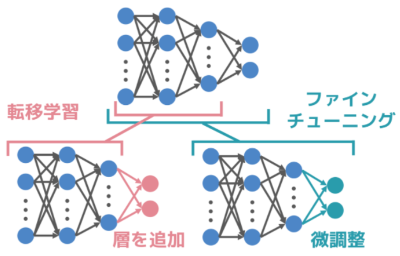






**画像分類器の訓練**


以下の手順に従って実施します：

1. ``torchvision``を用いた、CIFAR10の訓練データとテストデータの読み込みと正規化
2. 学習済みVGG16モデルの読み込みとテスト
3. 学習済みResNet50モデルの読み込みとテスト

今回は、最初からGPUを使用します。

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

In [ ]:
# データの前処理
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10データセットの読み込み
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 画像の表示関数


def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

[3] VGGモデルの読み込み
---

VGGネットワークは、シンプルな構造と小さなフィルタを使用して高い精度を発揮することで知られています。このモデルは、畳み込み層とプーリング層から構成されており、その構造は理解しやすく、深層学習の初学者にも使いやすいです。

#### VGGの特徴
- **シンプルな構造**: VGGは層を重ねることで複雑な特徴を捉えますが、その基本構造は単純で、畳み込み層とプーリング層が交互に配置されています。
- **小さなフィルタの使用**: VGGでは、3x3の小さなフィルタを用いた畳み込み層が特徴です。これにより、層を深くすることで精度を高めています。
- **問題点**: しかし、ネットワークが深くなるにつれて計算量が増大し、学習に時間がかかるという問題があります。


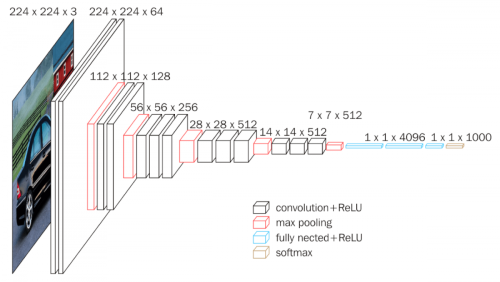

学習済みVGG16モデルの読み込みます。

In [ ]:
# 学習済みVGG16モデルの読み込み
vgg16 = torchvision.models.vgg16(pretrained=True)

VGG16はもともと1000クラスの分類問題を解決するように設計されているため10クラスの分類タスクに対応するようめ最終出力層を新しい線形層（nn.Linear）に置き換えて、出力数を10に変更します。

VGG16モデルをCIFAR10データセットの**転移学習**させます。

In [ ]:
# 出力層の調整
vgg16.classifier[6] = nn.Linear(4096, 10)

VGG16のモデルの構造を見てみます。

In [ ]:
print(vgg16)

GPUで実行させます。

In [ ]:
# GPUへ転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# 他の層のパラメータを固定（勾配計算を無効化）
for param in vgg16.parameters():
    param.requires_grad = False

# 最終層のパラメータのみ勾配計算を有効化
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()

# 最終層のパラメータのみを更新するようにoptimizerを設定
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

ネットワークの訓練


In [ ]:
# 訓練　GPUで10分程度
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch: %d | Loss: %.3f' % (epoch + 1, running_loss / (i + 1)))

print('Finished Training')

In [ ]:
# テスト
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        #outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

テストデータでモデルをテスト


In [ ]:
# いくつかのランダムなテスト画像を取得
dataiter = iter(testloader)
images, labels = next(iter(dataiter))

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# モデルによる予測
outputs = vgg16(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


テストデータセット全体に対する精度を確認します。

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

テストデータセットの各ラベルの予測精度を確認します。

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

ゼロから学習させた時の比較してかなりの精度になりました。



---



[6] ResNetの定義
---

### 深層残差ネットワーク（ResNet）

深層残差ネットワーク（Deep Residual Network）、通称ResNetは、2015年にKaiming Heらによって提案された、画像分類タスクにおいて高い性能を示すネットワークアーキテクチャです。ResNetはその後の多くのモデルに影響を与え、深層学習分野において重要な位置を占めています。

#### ResNet50の特徴
- **層の数**: ResNet50は、50層の畳み込み層を持つ深層ネットワークです。
- **事前学習済み重み**: ImageNetデータセットで事前学習された重みを活用できます。
- **残差ブロック**: ResNetの主要な特徴は、残差ブロック（Residual Block）です。このブロックは、層間にスキップ接続（Skip Connection）またはショートカット接続（Shortcut Connection）を追加することで、勾配消失問題を軽減し、深いネットワークの効果的な学習を可能にします。

#### 残差ブロックの仕組み
- **スキップ接続**: 層の入力が直接出力に加算されることで、ネットワークは恒等関数の学習に注力できます。
- **学習の効率化**: ネットワークは層の出力が入力に近いことを学習し、効果的な学習が可能になります。

#### ResNet50の構成要素
1. **初期特徴抽出**: 畳み込み層とプーリング層により行われます。
2. **4つの畳み込み層グループ**: 各グループには異なる数の残差ブロックが含まれています。
3. **グローバル平均プーリング層**: データの空間的特徴を集約します。
4. **全結合層**: 最終的なクラス分類を行います。

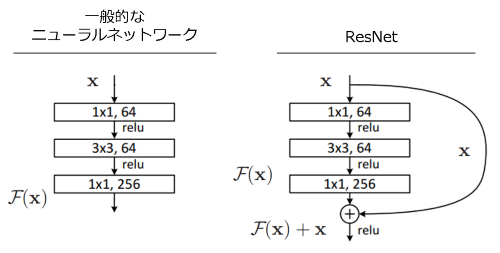

In [ ]:
# 訓練　GPUで30分程度

# 学習済みResNet50モデルの読み込み
resnet50 = torchvision.models.resnet50(pretrained=True)

# 出力層の調整
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

print(resnet50)

# GPUへ転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001) #, momentum=0.9)


モデルを再学習させる。

In [ ]:
# 訓練　GPUで30分程度かかります。
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch: %d | Loss: %.3f' % (epoch + 1, running_loss / (i + 1)))

print('Finished Training')

テストデータセットの各ラベルの予測精度を確認します。

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



---




### VGG16とResNet50のCIFAR10データセットにおける性能差

VGG16とResNet50は、CIFAR10データセットで異なる性能を示します。

#### アーキテクチャの違い
- **VGG16**: シンプルでフラットな構造を持ちます。
- **ResNet50**: より深い構造で、残差ブロックを使用しています。
- **影響**: これらの構造的な違いが、特定のタスクやデータセットにおいて異なる性能を引き出します。

#### 学習率と収束速度
- **VGG16 vs ResNet50**: 両者は異なるアーキテクチャを持つため、学習率や収束速度に差があります。
- **短いエポック数の影響**: 短期間の学習では、収束が早いモデルが優れた性能を示すことがあります。特に、ResNet50は深いネットワークなので、適切な学習率やエポック数の設定が重要です。

#### 事前学習の違い
- **データセット**: VGG16とResNet50は異なるデータセットで事前学習されています。
- **影響**: この事前学習の違いは、モデルの初期重みと特徴抽出能力に影響を与え、結果として異なる性能を生み出します。

#### 過学習
- **バッチサイズの影響**: バッチサイズが小さい場合、過学習が性能差を生じさせることがあります。
- **対策**: 過学習を軽減するためには、適切な正則化手法やデータ拡張の使用が重要です。




---



# 演習

## 調べてみよう。
- Pytorchドキュメントで事前学習モデルを調べてみよう。

[TORCHVISION.MODELS](https://pytorch.org/vision/0.9/models.html)